# Anak Agung Ngurah Bagus Trihatmaja - DS5500

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.mosaicplot import mosaic

In [34]:
df = pd.read_csv("./adult.data", skipinitialspace=True, header=None, na_values='?')

-----------------------------------------------------------------------------------------------


Explore the data and create visualizations 1 & 2. Do visualization write-ups 1 & 2 in markup below them. 

In [35]:
# Sanity check
df.isnull().sum()

0        0
1     1836
2        0
3        0
4        0
5        0
6     1843
7        0
8        0
9        0
10       0
11       0
12       0
13     583
14       0
dtype: int64

In [36]:
# Data cleaning
df = df.dropna()

In [37]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'labels']

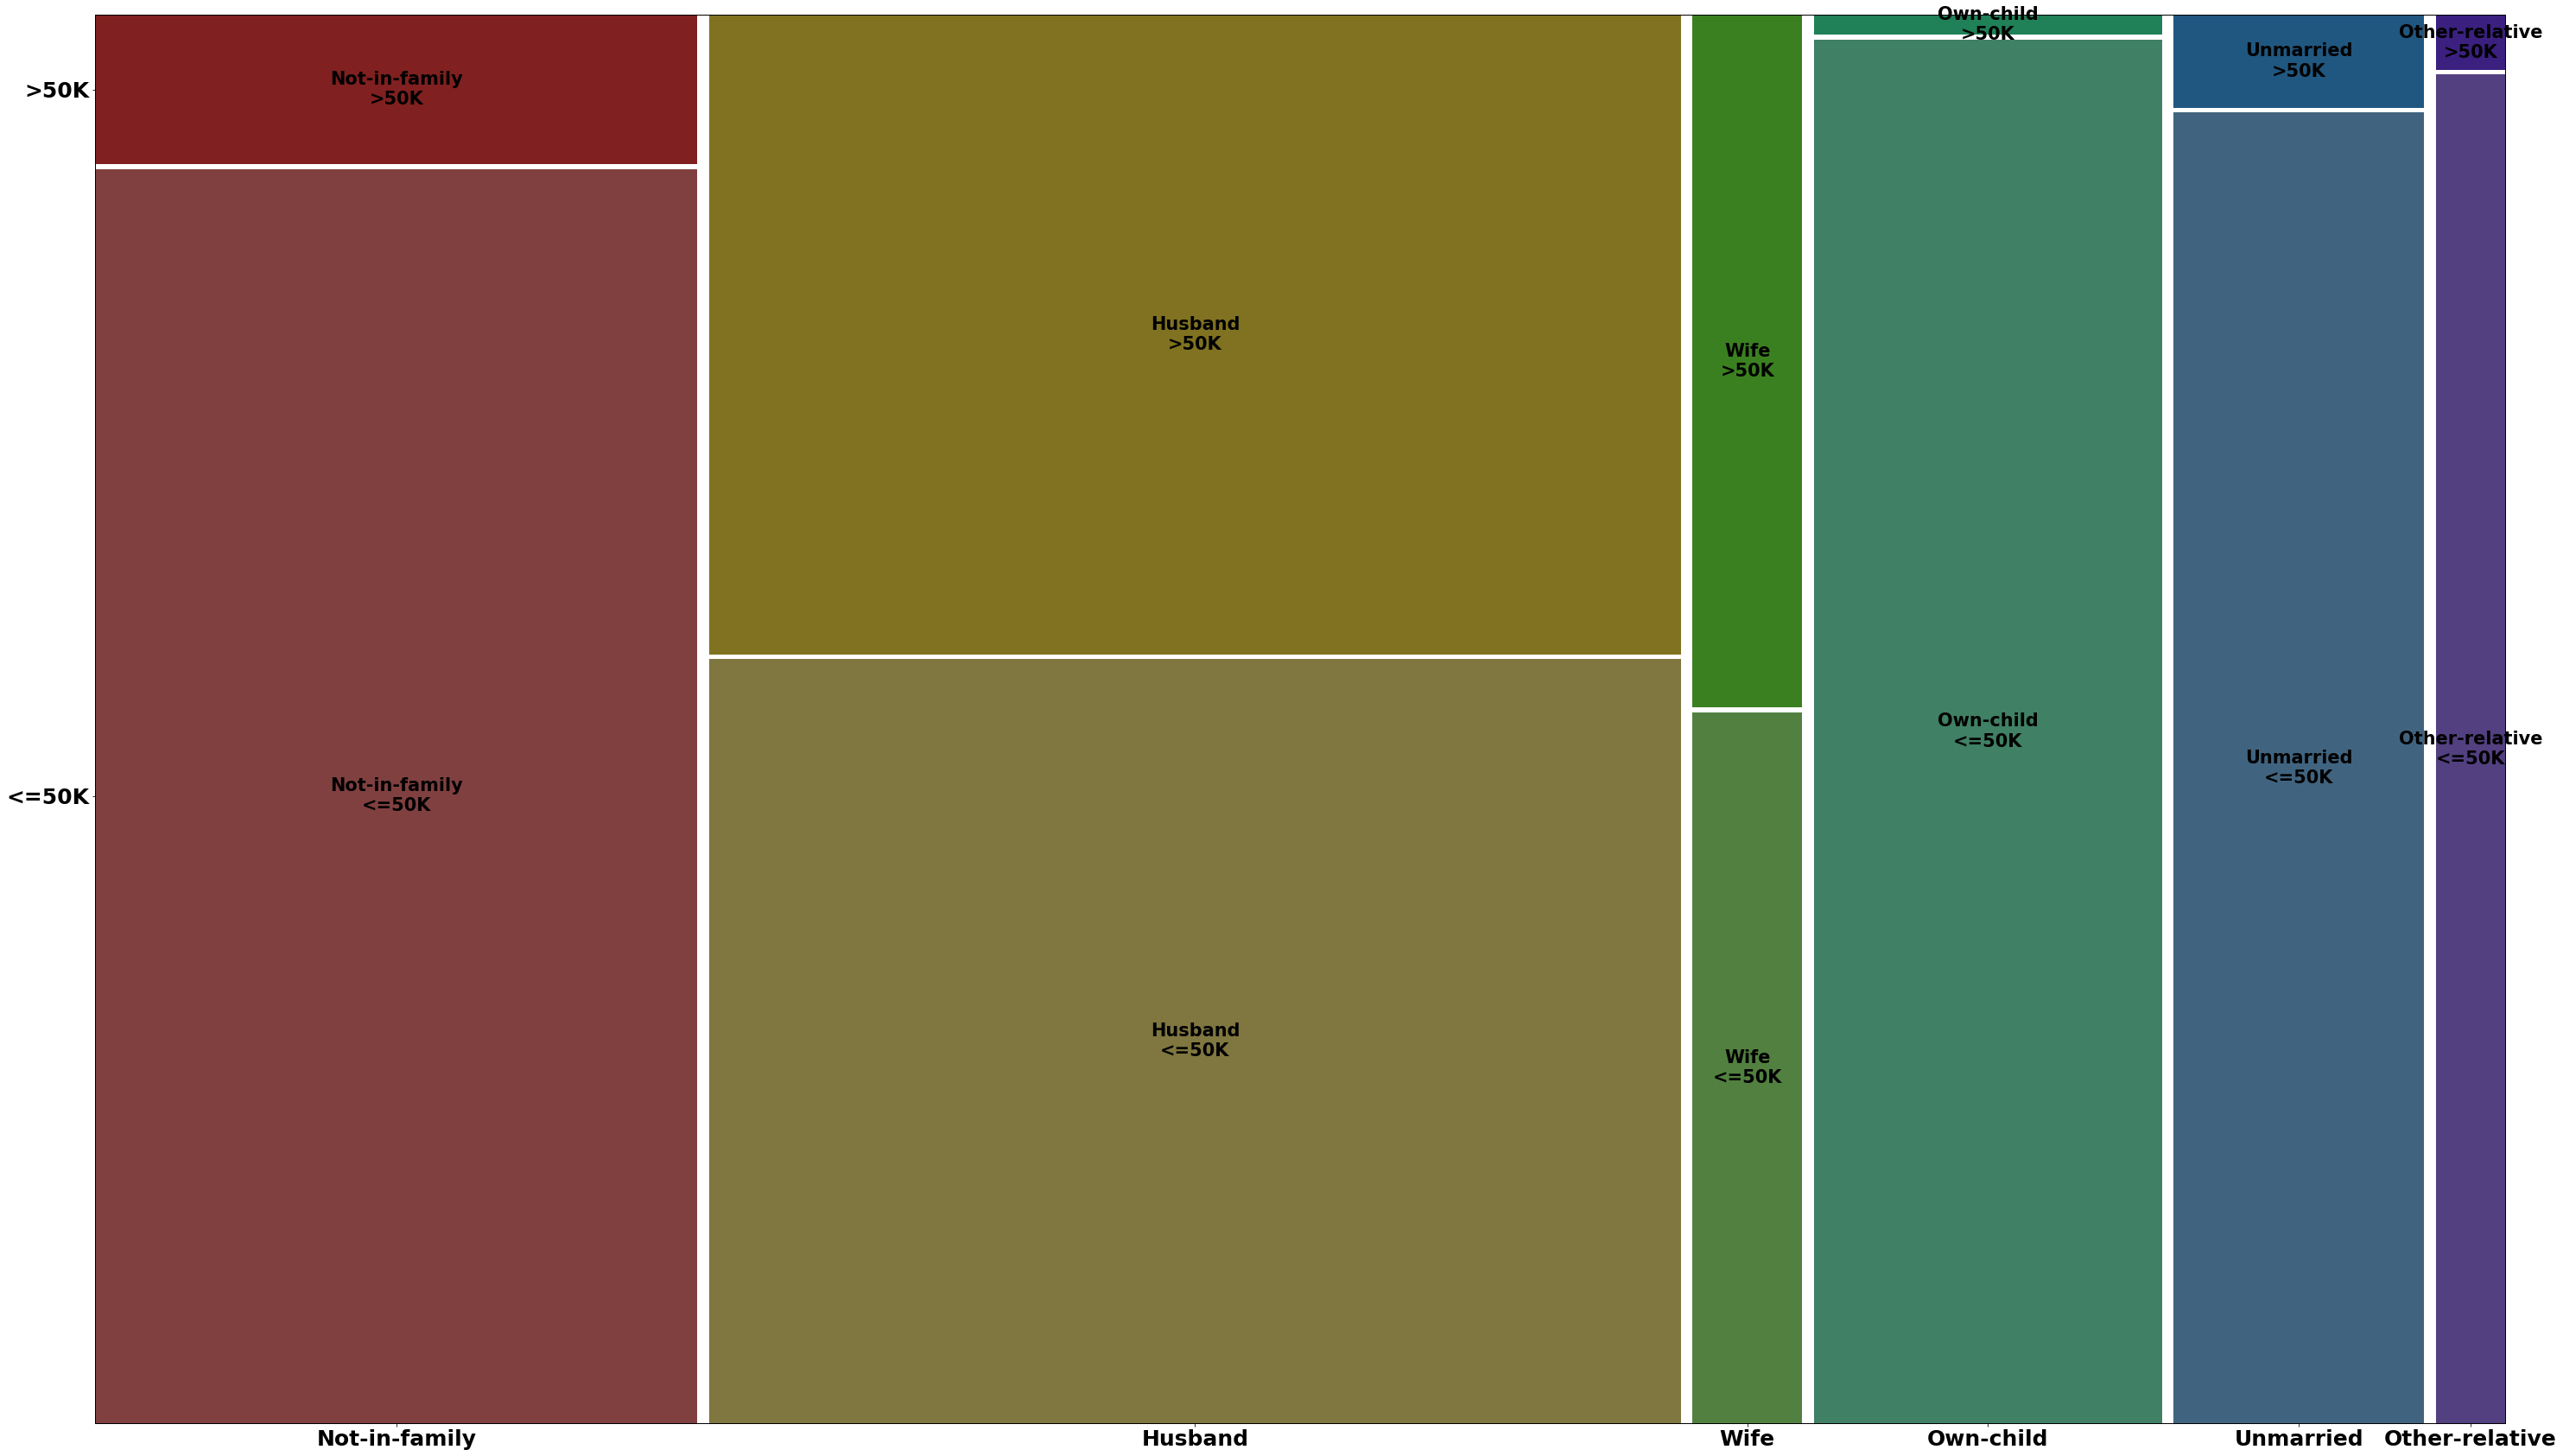

In [160]:
font = {'size': 25}

plt.rc("figure", figsize=(50,30))
plt.rc("font", **font)
mosaic(df, ['relationship', 'labels'])
plt.show()

Inspired from: http://datavis.ca/papers/casm/casm#tth_sEc3.3

Most of the data are categorical data. Therefore, it makes sense to visualize the distribution of the categorical data in respect to the target label. Here we use mosaic plot as our visual encoding. The marker of this visualization will be area where we utilize color as a channel to show each category and also the area to show the proportion. This turns out to be very effective to show categorical data. The problem in this visualization is if we have many categories, it will be harder to see.

For this assignment, we show only one plot. If we want to show multivariate variables, then it will make sense to make a facet or subplots of this.

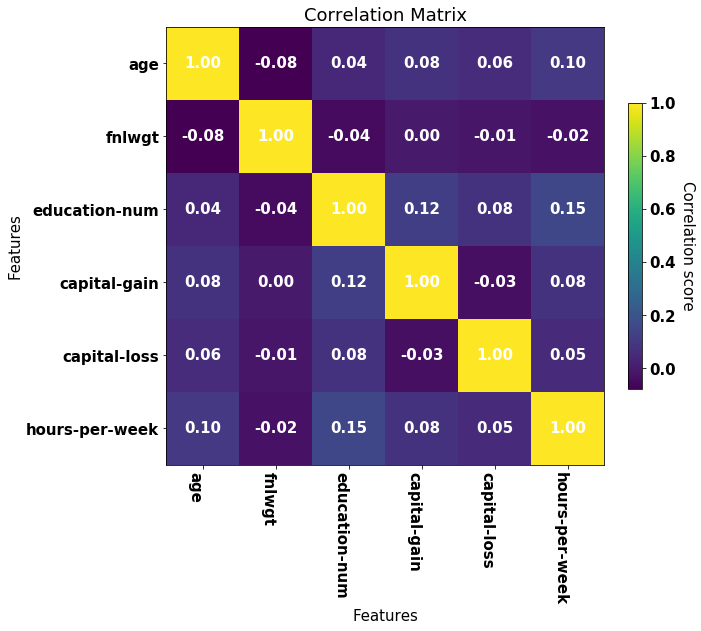

In [187]:
font = {'size': 15}

plt.rc("font", **font)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(df.corr())
# Create colorbar
cbarlabel="Correlation score"

cbar = ax.figure.colorbar(im, ax=ax,cmap= "YlGn", orientation='vertical', fraction=.03)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# We want to show all ticks...
ax.set_xticks(np.arange(0, 6))
ax.set_yticks(np.arange(0, 6))
# ... and label them with the respective list entries
ax.set_xticklabels(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])
ax.set_yticklabels(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-90, ha="right")

matrix_np = np.array(df.corr())
# Loop over data dimensions and create text annotations.
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, "{0:.2f}".format(matrix_np[i, j]),
                       ha="center", va="center", color="w")

ax.set_xlabel("Features")
ax.set_ylabel("Features")
ax.set_title("Correlation Matrix")
fig.tight_layout()
plt.show()

Correlation is useful for reducing the dimension. In this plot we visualize the correlation matrix between variables as a heat map. Since color can be tricky as a channel. We annotate a text to clearly show the number as another marker. 

-------------------------------------------------------------------------------------
Preprocess the data properly (for instance: one-hot encoding for categorical features, standardization for continuous features). You must normalize the data using only information the training data (ex: don’t normalize by the mean of all data points). Write a few sentences in markup explaining how you preprocessed the data and why you did it this way

In [38]:
Y = df['labels']
X = df.loc[:,'age':'native-country']

In [39]:
X = pd.get_dummies(X, columns=categorical_columns, sparse=True)
lb = LabelBinarizer()
Y = lb.fit_transform(Y)

We encode the categorical data as One-Hot-Encoding, the reason is because most of categorical data here is not ordinal. For example: gender. There is no order between male and female. As KNN measure closeness, it is important to assign the same importance to them.

------------------------------------------------------------------


Split the dataset randomly into train/test (80/20)

In [55]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [56]:
# Normalize
scaler = StandardScaler()

X_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
X_test[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.transform(X_test[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

/home/prdx/.local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/prdx/.local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/prdx/.local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

-----------------------------------------------------------------------------------------------
Use a grid search over K (1-10) and p (l1 or l2 distance) and 10 fold CV on the training set to select the optimal values for the hyperparameter K and p

In [60]:
k_range = list(range(1, 11))
p_range = list(range(1,3))
param_grid = dict(n_neighbors=k_range, p = p_range)

In [61]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=8)

In [62]:
grid.fit(X_train, y_train)

/home/prdx/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [104]:
# Collecting the result
matrix = pd.DataFrame()

for i in range(10):
    col = list()
    col_name = "split" + str(i) + "_test_score"
    for j in range(1, 21):
        if j % 2 == 0:
            col.append(float("{0:.2f}".format(grid.cv_results_[col_name][j - 1])))
    matrix[i] = col

In [105]:
matrix_np = matrix.as_matrix()

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


-------------------------------------------------------------------------

Visualize performance of the algorithm across various values for K (holding p constant at it’s default value of 2 here). Since you’re doing 10-fold cv for each value of K, you actually have 100 values total (10 values for each of the 10 values of K). Please find an appropriate way to encode this data (don’t just make a line chart with the means!)

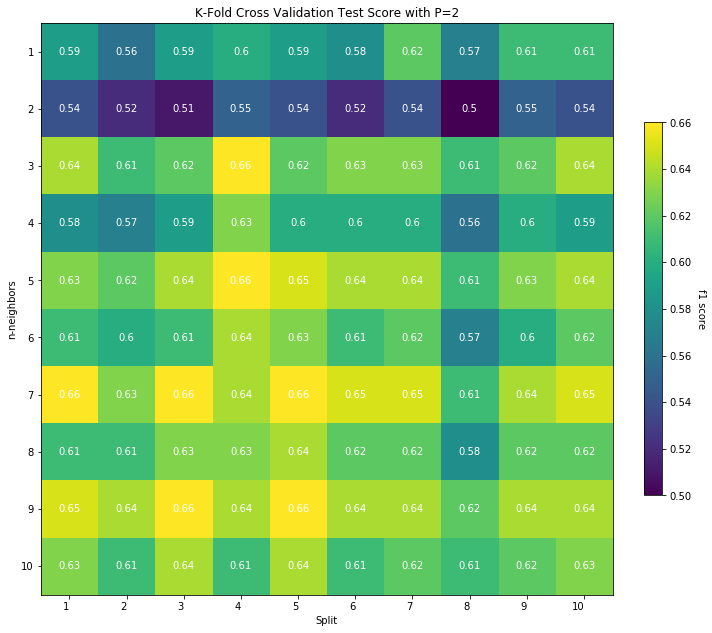

In [147]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(matrix)
# Create colorbar
cbarlabel="f1 score"

cbar = ax.figure.colorbar(im, ax=ax,cmap= "YlGn", orientation='vertical', fraction=.03)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# We want to show all ticks...
ax.set_xticks(np.arange(0, 10))
ax.set_yticks(np.arange(0, 10))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(1, 11))
ax.set_yticklabels(np.arange(1, 11))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, matrix_np[i, j],
                       ha="center", va="center", color="w")

ax.set_xlabel("Split")
ax.set_ylabel("n-neighbors")
ax.set_title("K-Fold Cross Validation Test Score with P=2")
fig.tight_layout()
plt.show()

Inspired by: https://homes.cs.washington.edu/~jheer/files/zoo/

There are three components we want to visualize. The first one is the parameter n-neighbors, the second one is the split, and the third one is the f1 score. Thus it makes sense to show it as a matrix view. Like heatmap we also use color as a channel and we help we text as annotation.

In [63]:
# Get the best score and params
print(grid.best_score_)
print(grid.best_params_)

0.6447749604095486
{'n_neighbors': 7, 'p': 2}


Using the optimal hyperparameters, predict the values for your test set and report performance (must use an appropriate and meaningful evaluation metric for this classification task)

In [64]:
classifier = KNeighborsClassifier(n_neighbors=7, p=2)  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)  

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [119]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[4075,  428],
       [ 575,  955]])

In [121]:
# Precision, recall and f1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4503
           1       0.69      0.62      0.66      1530

   micro avg       0.83      0.83      0.83      6033
   macro avg       0.78      0.76      0.77      6033
weighted avg       0.83      0.83      0.83      6033



In [122]:
# Accuracry
print(classifier.score(X_test, y_test))

0.8337477208685563


-------------------------------------------------------------

To make it faster, we could perform PCA to reduce the dimensions. Or do the feature selection as we know the correlation between variables.